# 02 — Plot Soundings Ranges

In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import glob
import matplotlib.pyplot as plt
from metpy.units import units
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')


# --- CONFIGURATION (Adjust Paths as needed) ---

REPO_ROOT = Path.cwd().parents[0] if (Path.cwd().name == 'notebooks') else Path.cwd()
SRC = REPO_ROOT / 'src'
sys.path.append(str(SRC))

try:
    from core.sounding_generator import (generate_sounding,
                                         read_input_sounding, 
                                         write_input_sounding,
                                         calculate_diagnostics)
    from core.plot_utils import prepare_skewt_hodograph, plot_sounding,plot_sounding_full
except ImportError:
    print("ERROR: Could not import 'sounding_generator'.")
    print("Make sure 'sounding_generator.py' exists in the 'src/core/' directory.")
    sys.exit(1)

EXPERIMENT_DIR = str(REPO_ROOT / 'outputs' / 'sobol_exp_default')
BASE_SOUNDING = str(SRC / 'input_sounding')  # Your base sounding file
SOUNDINGS_DIR = str(REPO_ROOT / 'outputs' / 'sobol_exp_default' / 'soundings')

DIAGNOSTICS_FILE = str(REPO_ROOT / 'outputs' / 'sobol_exp_default' / 'soundings' / 'diagnostics.pkl')
VIABLE_SAMPLES_FILE = os.path.join(EXPERIMENT_DIR, 'soundings/viable_sample_ids.npy')
# --- LOAD DATA ---
try:
    # Load parameter metadata (for names) and all parameters
    with open(os.path.join(EXPERIMENT_DIR, 'problem.pkl'), 'rb') as f:
        problem = pickle.load(f)
    param_values = np.load(os.path.join(EXPERIMENT_DIR, 'param_values.npy'))
    
    # Load all MetPy diagnostic data (for filtering check)
    with open(DIAGNOSTICS_FILE, 'rb') as f:
        diagnostics = pickle.load(f)
        
    # Load the indices of the soundings that passed the filter (424 indices)
    viable_indices = np.load(VIABLE_SAMPLES_FILE)
    print(f"Loaded {len(viable_indices)} viable sample indices.")
    
except FileNotFoundError as e:
    print(f"Error: Missing experiment file. Ensure steps 1, 2, and 2b were run. \nDetails: {e}")
    # Handle error or exit
#
# --- Filter diagnostics to viable samples only ---
# Create an index mask if your diagnostics.pkl is a flat list
# This assumes the 'sample_id' array in diagnostics tracks the original index
viable_mask = np.isin(diagnostics['sample_id'], viable_indices)

# Extract MUCAPE statistics for the final plot title/summary
viable_mucape = np.array(diagnostics['mucape'])[viable_mask]
print(f"Viable MUCAPE Range: Min={np.min(viable_mucape):.0f} J/kg, Max={np.max(viable_mucape):.0f} J/kg")

Loaded 5480 viable sample indices.
Viable MUCAPE Range: Min=13 J/kg, Max=8241 J/kg


In [2]:
# --- COLLECT PROFILES ---
all_heights = []
all_theta = []
all_t = []
all_qv = []
all_u = []
all_v = []

# Get the list of file paths corresponding to the viable indices
viable_sounding_paths = [
    os.path.join(SOUNDINGS_DIR, f'input_sounding_{i:05d}') 
    for i in viable_indices
]

sounding = read_input_sounding(viable_sounding_paths[0])
all_heights = sounding['height']

N_levels = len(all_heights)
N_samples = len(viable_indices)
all_t = np.zeros((N_samples, N_levels))
all_qv = np.zeros((N_samples, N_levels))
all_u = np.zeros((N_samples, N_levels))
all_v = np.zeros((N_samples, N_levels))
sample_idx = 0
for file_path in viable_sounding_paths:
    try:
        # Read the WRF input file (uses the function assumed to be in sounding_generator.py)
        sounding = read_input_sounding(file_path)
        # Note: T is recalculated from theta/P in read_input_sounding
        all_t[sample_idx, :] = sounding['t']
        all_qv[sample_idx, :] = sounding['qv']
        all_u[sample_idx, :] = sounding['u']
        all_v[sample_idx, :] = sounding['v']

        sample_idx += 1
        
    except FileNotFoundError:
        # This shouldn't happen if Step 2 ran successfully
        print(f"Warning: Sounding file not found for index {file_path}")
        continue
    except Exception as e:
        # Catches cases where MetPy calculation failed or file read error
        print(f"Warning: Failed to process sounding {file_path}. Error: {e}")
        continue

# Resize arrays to actual number of successfully loaded samples
all_t = all_t[:sample_idx, :]
all_qv = all_qv[:sample_idx, :]
all_u = all_u[:sample_idx, :]
all_v = all_v[:sample_idx, :]

# Calculate the envelope (Min/Max/Mean) for each variable
t_min, t_max, t_mean = all_t.min(axis=0), all_t.max(axis=0), all_t.mean(axis=0)
qv_min, qv_max, qv_mean = all_qv.min(axis=0), all_qv.max(axis=0), all_qv.mean(axis=0)
u_min, u_max, u_mean = all_u.min(axis=0), all_u.max(axis=0), all_u.mean(axis=0)
v_min, v_max, v_mean = all_v.min(axis=0), all_v.max(axis=0), all_v.mean(axis=0)


# Conversion from T (K) to C
t_min_c = t_min - 273.15
t_max_c = t_max - 273.15
t_mean_c = t_mean - 273.15

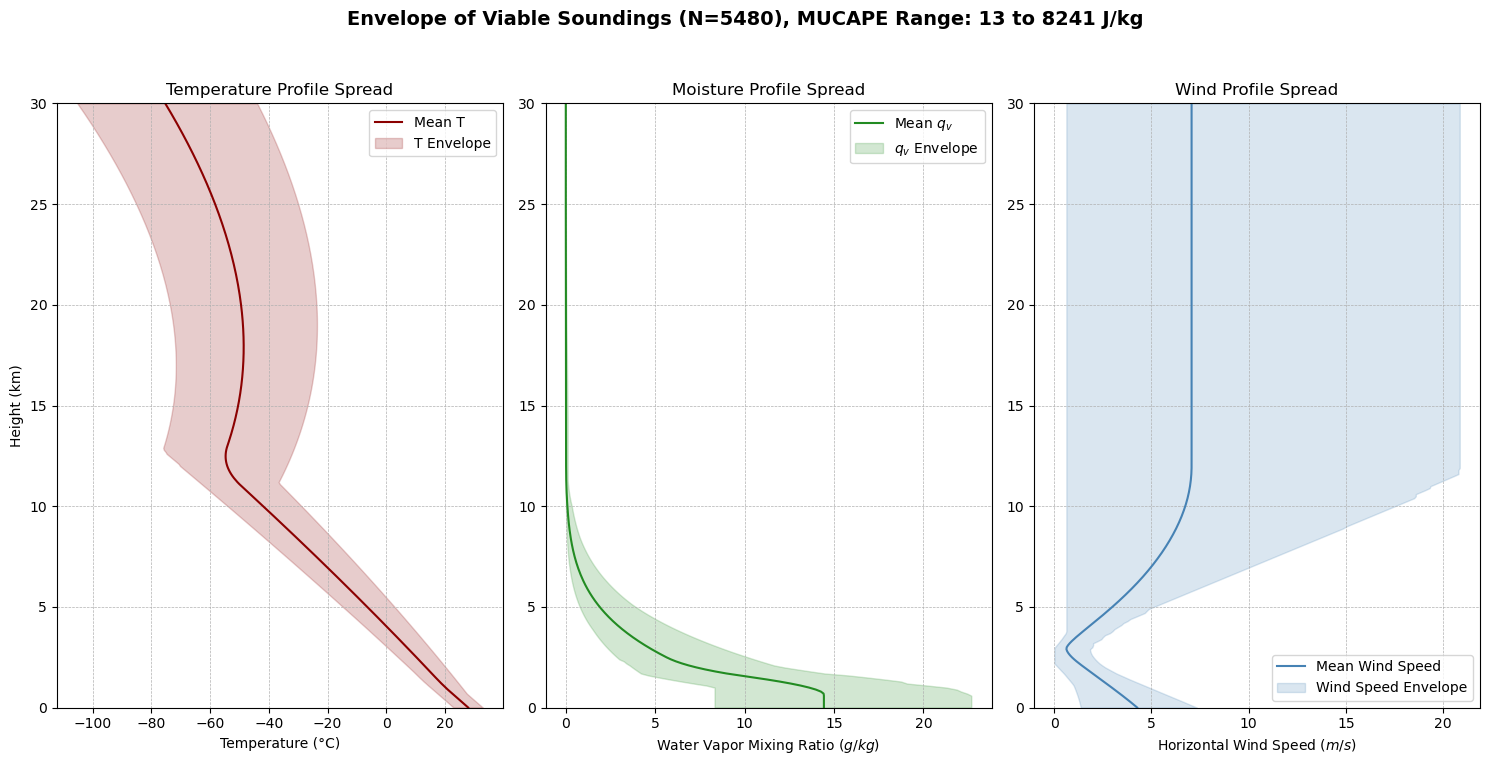

In [3]:
# --- PLOT ENVELOPE ---
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
height_km = all_heights / 1000.0

# 1. Temperature Profile Envelope
ax0 = axes[0]
ax0.plot(t_mean_c, height_km,  color='DarkRed', label='Mean T')
ax0.fill_betweenx(height_km, t_min_c, t_max_c, color='DarkRed', alpha=0.2, label='T Envelope')
ax0.set_xlabel('Temperature (°C)')
ax0.set_ylabel('Height (km)')
ax0.set_title('Temperature Profile Spread')
ax0.set_ylim(0, np.max(height_km))
ax0.grid(True, linestyle='--', linewidth=0.5)
ax0.legend()

# 2. Moisture Profile Envelope (Mixing Ratio)
ax1 = axes[1]
ax1.plot(qv_mean, height_km, color= 'ForestGreen', label='Mean $q_v$')
ax1.fill_betweenx(height_km, qv_min, qv_max, color='ForestGreen', alpha=0.2, label='$q_v$ Envelope')
ax1.set_xlabel('Water Vapor Mixing Ratio ($g/kg$)')
ax1.set_title('Moisture Profile Spread')
ax1.set_ylim(0, np.max(height_km))
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.legend()

# 3. Wind Speed (Magnitude) Envelope - Shear Profile
# Calculate wind speed magnitude for min/max lines
wind_speed_mag = np.sqrt(all_u**2 + all_v**2)
ws_min, ws_max, ws_mean = wind_speed_mag.min(axis=0), wind_speed_mag.max(axis=0), wind_speed_mag.mean(axis=0)

ax2 = axes[2]
ax2.plot(ws_mean, height_km, color = 'SteelBlue', label='Mean Wind Speed')
ax2.fill_betweenx(height_km, ws_min, ws_max, color='SteelBlue', alpha=0.2, label='Wind Speed Envelope')
ax2.set_xlabel('Horizontal Wind Speed ($m/s$)')
ax2.set_title('Wind Profile Spread')
ax2.set_ylim(0, np.max(height_km))
ax2.grid(True, linestyle='--', linewidth=0.5)
ax2.legend()

fig.suptitle(f'Envelope of Viable Soundings (N={len(viable_indices)}), MUCAPE Range: {np.min(viable_mucape):.0f} to {np.max(viable_mucape):.0f} J/kg', 
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

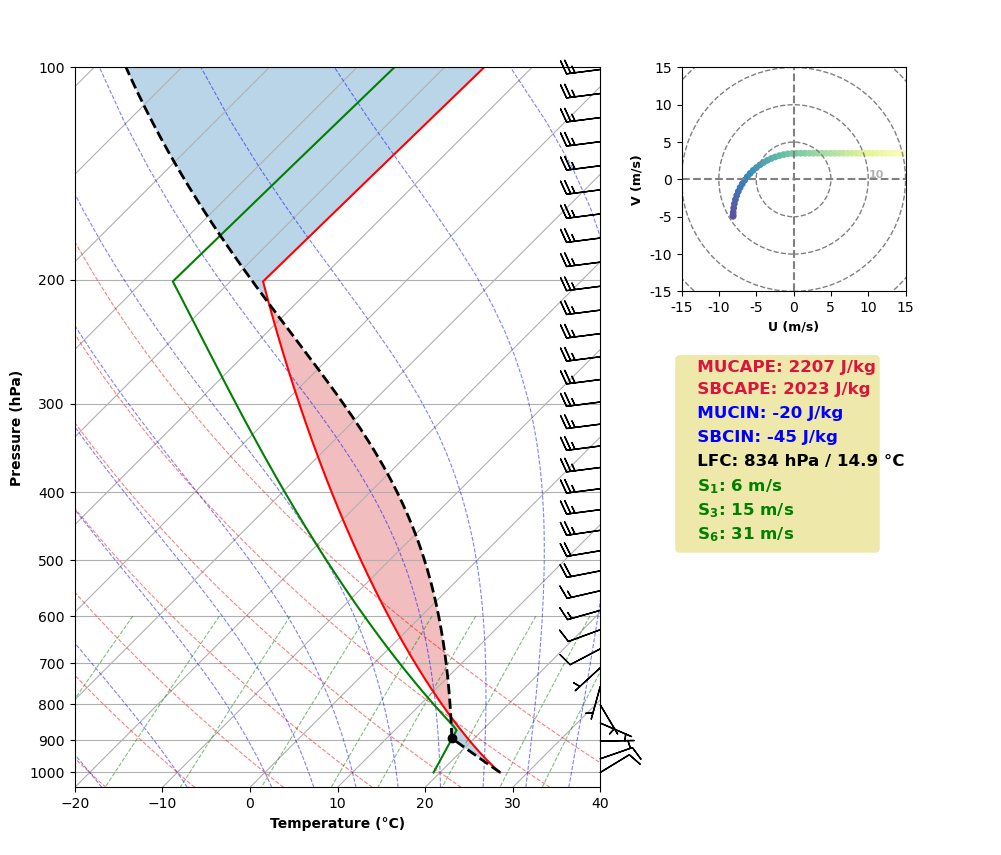

In [4]:
baseline_sounding=read_input_sounding(BASE_SOUNDING)
fig, skew, h, ax = plot_sounding_full(baseline_sounding)

In [5]:
viable_df = pd.DataFrame({
    'sample_id': np.array(diagnostics['sample_id'])[viable_mask],
    'mucape': np.array(diagnostics['mucape'])[viable_mask],
    'mucin': np.array(diagnostics['mucin'])[viable_mask],
    'shear_0_1km': np.array(diagnostics['shear_0_1km'])[viable_mask],
    'shear_0_6km': np.array(diagnostics['shear_0_6km'])[viable_mask],
    'pwat': np.array(diagnostics['pwat'])[viable_mask]
})

print(f"\nTotal viable soundings: {len(viable_df)}")
print("\n=== Identifying Representative Cases ===")

# --- 1. Identify Key Cases ---
cases = {}

# CAPE extremes
cases['Min CAPE'] = viable_df.loc[viable_df['mucape'].idxmin()]
cases['Max CAPE'] = viable_df.loc[viable_df['mucape'].idxmax()]
cases['Median CAPE'] = viable_df.loc[(viable_df['mucape'] - viable_df['mucape'].median()).abs().idxmin()]

# Shear extremes
cases['Min Shear'] = viable_df.loc[viable_df['shear_0_6km'].idxmin()]
cases['Max Shear'] = viable_df.loc[viable_df['shear_0_6km'].idxmax()]

# Interesting combinations
# High CAPE + High Shear (supercell favorable)
cape_q75 = viable_df['mucape'].quantile(0.75)
shear_q75 = viable_df['shear_0_6km'].quantile(0.75)
supercell_mask = (viable_df['mucape'] >= cape_q75) & (viable_df['shear_0_6km'] >= shear_q75)
if supercell_mask.sum() > 0:
    supercell_cases = viable_df[supercell_mask]
    # Pick the most extreme within this group
    cases['Supercell-Favorable'] = supercell_cases.loc[
        (supercell_cases['mucape'] * supercell_cases['shear_0_6km']).idxmax()
    ]

# High CAPE + Low Shear (multicell/pulse)
cape_q75 = viable_df['mucape'].quantile(0.75)
shear_q25 = viable_df['shear_0_6km'].quantile(0.25)
pulse_mask = (viable_df['mucape'] >= cape_q75) & (viable_df['shear_0_6km'] <= shear_q25)
if pulse_mask.sum() > 0:
    cases['Pulse/Multicell'] = viable_df[pulse_mask].loc[viable_df[pulse_mask]['mucape'].idxmax()]

# Print summary
for case_name, case_data in cases.items():
    print(f"\n{case_name:20s} → Sample {int(case_data['sample_id']):05d}: "
          f"CAPE={case_data['mucape']:.0f} J/kg, "
          f"Shear={case_data['shear_0_6km']:.1f} m/s")




Total viable soundings: 5480

=== Identifying Representative Cases ===

Min CAPE             → Sample 04933: CAPE=13 J/kg, Shear=5.1 m/s

Max CAPE             → Sample 00763: CAPE=8241 J/kg, Shear=11.4 m/s

Median CAPE          → Sample 02488: CAPE=2329 J/kg, Shear=11.7 m/s

Min Shear            → Sample 04870: CAPE=1720 J/kg, Shear=1.9 m/s

Max Shear            → Sample 04968: CAPE=3893 J/kg, Shear=15.0 m/s

Supercell-Favorable  → Sample 02843: CAPE=7881 J/kg, Shear=12.9 m/s

Pulse/Multicell      → Sample 01358: CAPE=7519 J/kg, Shear=5.0 m/s



=== Creating Panel Plot ===


AttributeError: 'Axes' object has no attribute 'add_subplot'

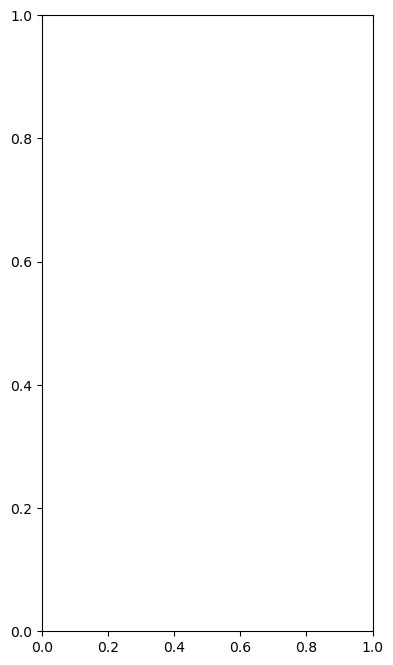

In [6]:

# --- 2. Panel Plot: Side-by-side Skew-Ts ---
print("\n=== Creating Panel Plot ===")

n_cases = len(cases)
fig = plt.figure(figsize=(5 * n_cases, 8))

for i, (case_name, case_data) in enumerate(cases.items()):
    # Load the sounding
    sample_id = int(case_data['sample_id'])
    sounding_path = os.path.join(SOUNDINGS_DIR, f'input_sounding_{sample_id:05d}')
    sounding = read_input_sounding(sounding_path)
    
    # Create a Skew-T subplot using plot_utils
    ax = plt.subplot(1, n_cases, i + 1)
    from metpy.plots import SkewT
    skew = SkewT(ax, rotation=45)
    
    # Configure axes
    skew.ax.set_xlim(-30, 40)
    skew.ax.set_ylim(1050, 100)
    skew.plot_dry_adiabats(linewidths=0.6, alpha=0.4)
    skew.plot_moist_adiabats(linewidths=0.6, alpha=0.4)
    skew.plot_mixing_lines(linewidths=0.6, alpha=0.4)
    
    # Plot the sounding using plot_utils
    plot_sounding(
        fig, skew, None, None, sounding,
        plot_temp=True,
        plot_dewpoint=True,
        plot_parcel=True,
        plot_cape_cin=True,
        plot_barbs=True,
        color_temp='crimson',
        color_dewpoint='forestgreen',
        alpha=0.9,
        linewidth=2,
        show=False
    )
    
    # Add title with key diagnostics
    title = (f"{case_name}\n"
             f"MUCAPE: {case_data['mucape']:.0f} J/kg\n"
             f"0-6km Shear: {case_data['shear_0_6km']:.1f} m/s")
    skew.ax.set_title(title, fontsize=11, fontweight='bold')
    
    # Only show y-label on leftmost plot
    if i > 0:
        skew.ax.set_ylabel('')
        skew.ax.set_yticklabels([])

plt.suptitle(f'Representative Soundings from Sobol Ensemble (N={len(viable_df)})',
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



=== Creating Overlay Plot ===


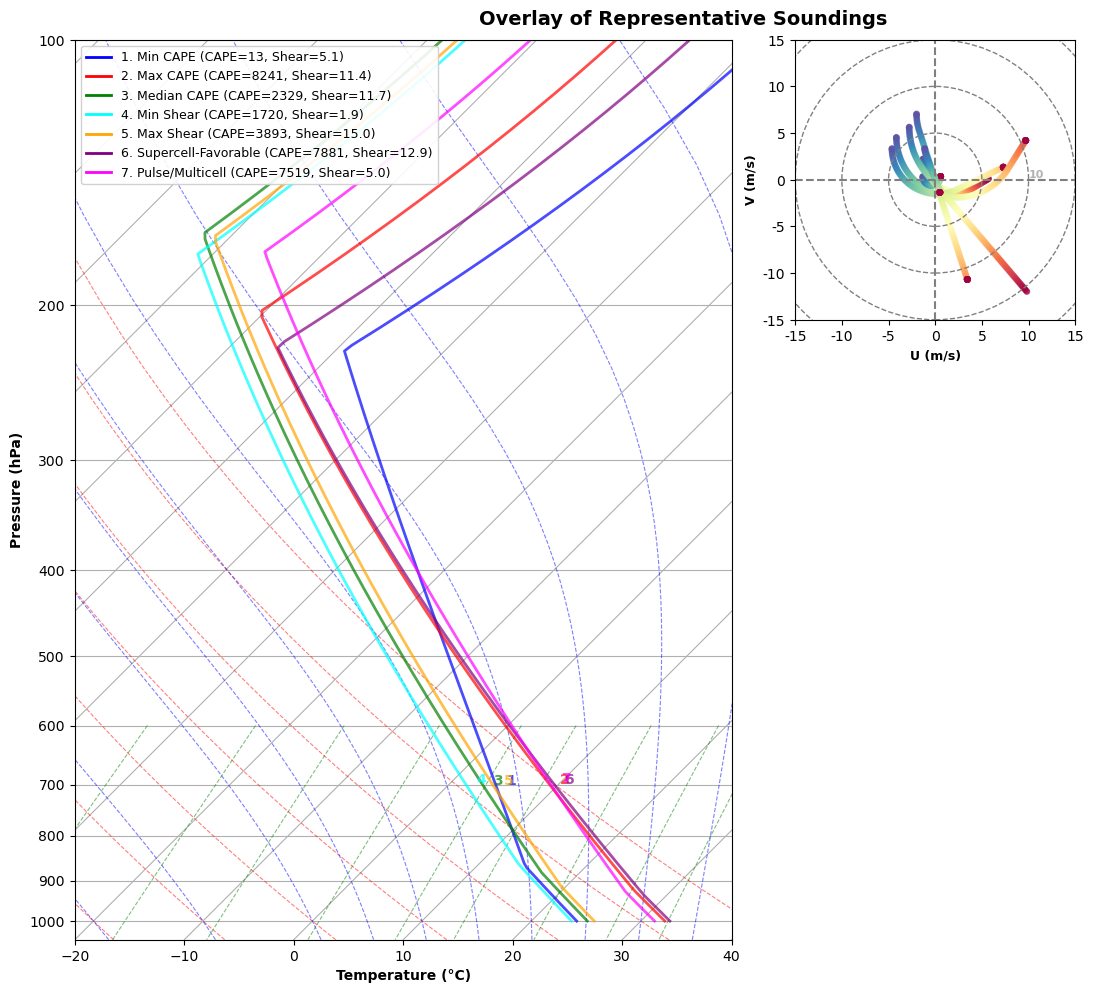


=== Full Diagnostic View ===
Showcasing: Supercell-Favorable
Sample ID: 02843
MUCAPE: 7881 J/kg
0-6km Shear: 12.9 m/s


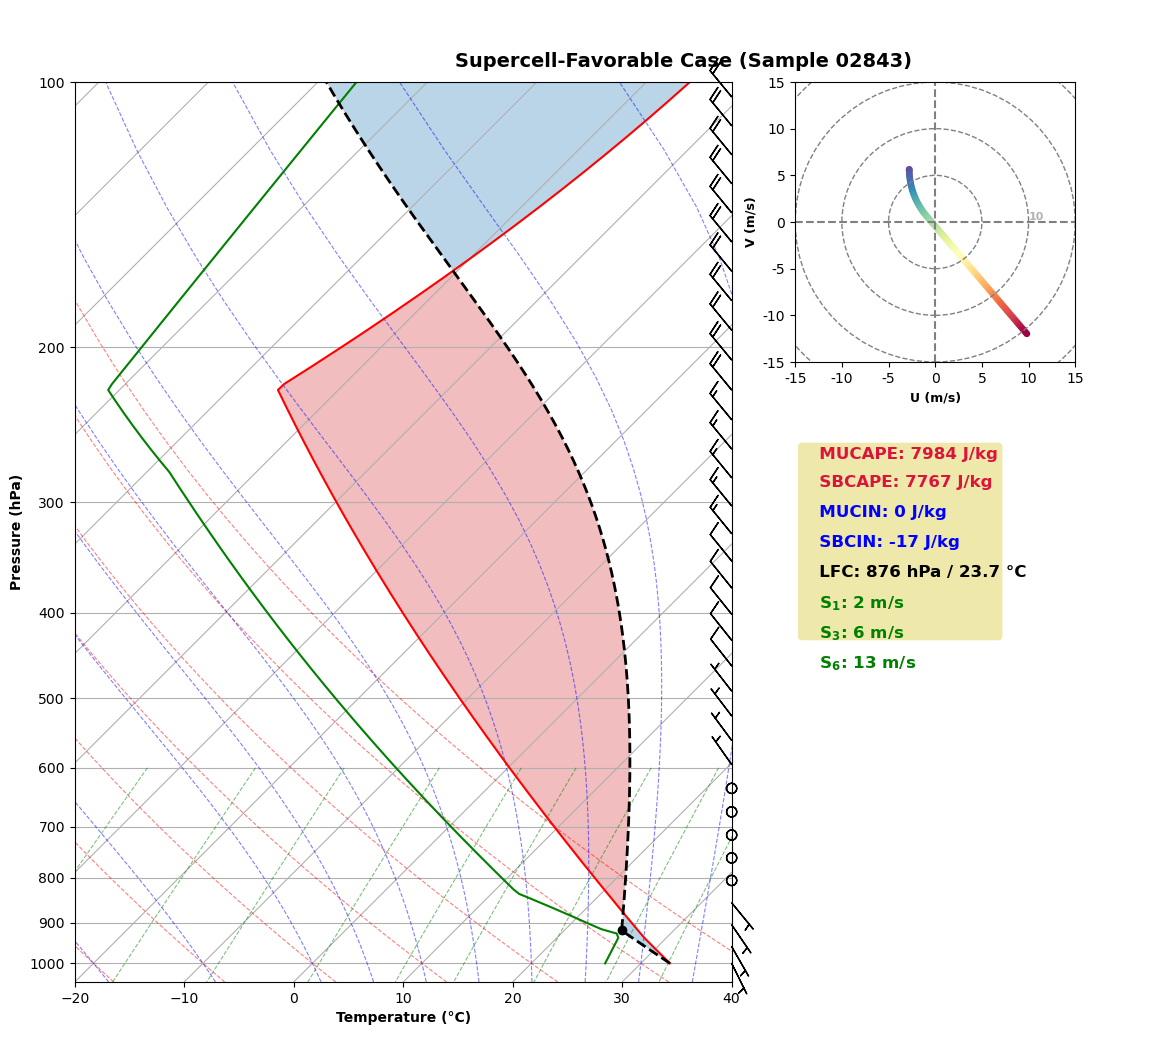


=== Creating Skew-T Envelope Plot ===
Loading viable soundings for envelope calculation...
Loaded 5480 soundings for envelope


ImportError: cannot import name 'plot_sounding_envelope' from 'core.plot_utils' (/nfsmounts/storage/scratch/jorge.gacitua/Supercell_WRF_Sensitivity/src/core/plot_utils.py)

In [ ]:


# --- 3. Overlay Plot: All key cases on one Skew-T ---
print("\n=== Creating Overlay Plot ===")

fig, skew, h, ax_indices = prepare_skewt_hodograph(
    include_hodograph=True,
    include_indices_box=False,
    figsize=(14, 10)
)

# Define colors for each case
colors = {
    'Min CAPE': 'blue',
    'Median CAPE': 'green',
    'Max CAPE': 'red',
    'Min Shear': 'cyan',
    'Max Shear': 'orange',
    'Supercell-Favorable': 'purple',
    'Pulse/Multicell': 'magenta'
}

# Plot each case
for i, (case_name, case_data) in enumerate(cases.items()):
    sample_id = int(case_data['sample_id'])
    sounding_path = os.path.join(SOUNDINGS_DIR, f'input_sounding_{sample_id:05d}')
    sounding = read_input_sounding(sounding_path)
    
    color = colors.get(case_name, f'C{i}')
    
    plot_sounding(
        fig, skew, h, None, sounding,
        plot_temp=True,
        plot_dewpoint=False,  # Too cluttered with multiple soundings
        plot_parcel=False,
        plot_hodograph=True,
        color_temp=color,
        alpha=0.7,
        linewidth=2,
        label=str(i+1),
        show=False
    )

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=colors.get(name, 'black'), lw=2, 
           label=f"{i+1}. {name} (CAPE={data['mucape']:.0f}, Shear={data['shear_0_6km']:.1f})")
    for i, (name, data) in enumerate(cases.items())
]
skew.ax.legend(handles=legend_elements, loc='upper left', fontsize=9, framealpha=0.9)

plt.suptitle('Overlay of Representative Soundings', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# --- 4. Full Diagnostic View: Pick ONE interesting case ---
print("\n=== Full Diagnostic View ===")

# Let's show the "Supercell-Favorable" case with all diagnostics
if 'Supercell-Favorable' in cases:
    showcase_case = 'Supercell-Favorable'
else:
    showcase_case = 'Max CAPE'

showcase_data = cases[showcase_case]
sample_id = int(showcase_data['sample_id'])
sounding_path = os.path.join(SOUNDINGS_DIR, f'input_sounding_{sample_id:05d}')
sounding = read_input_sounding(sounding_path)

print(f"Showcasing: {showcase_case}")
print(f"Sample ID: {sample_id:05d}")
print(f"MUCAPE: {showcase_data['mucape']:.0f} J/kg")
print(f"0-6km Shear: {showcase_data['shear_0_6km']:.1f} m/s")

# Use the convenience function for full diagnostic plot
fig, skew, h, ax_indices = plot_sounding_full(sounding, figsize=(14, 10), show=False)
fig.suptitle(f'{showcase_case} Case (Sample {sample_id:05d})', 
             fontsize=14, fontweight='bold')
plt.show()


# --- 5. Skew-T Envelope Plot ---
print("\n=== Creating Skew-T Envelope Plot ===")

# Load base sounding
base = read_input_sounding(BASE_SOUNDING)

# Load all viable soundings for envelope calculation
print("Loading viable soundings for envelope calculation...")
viable_soundings = []
for idx in viable_indices[:]:  # Use all viable soundings
    sounding_path = os.path.join(SOUNDINGS_DIR, f'input_sounding_{idx:05d}')
    try:
        snd = read_input_sounding(sounding_path)
        viable_soundings.append(snd)
    except:
        continue

print(f"Loaded {len(viable_soundings)} soundings for envelope")

# Use the new envelope plotting function
from core.plot_utils import plot_sounding_envelope

fig, skew = plot_sounding_envelope(
    base_sounding=base,
    sounding_list=viable_soundings,
    plot_base_temp=True,
    plot_base_dewpoint=True,
    plot_base_parcel=True,
    plot_base_cape_cin=True,
    plot_envelope_temp=True,
    plot_envelope_dewpoint=True,
    color_base_temp='black',
    color_base_dewpoint='darkgreen',
    color_envelope_temp='crimson',
    color_envelope_dewpoint='forestgreen',
    alpha_base=0.9,
    alpha_envelope=0.12,
    figsize=(12, 10),
    show=False
)

fig.suptitle(f'Base Sounding with Ensemble Envelope (N={len(viable_soundings)} viable soundings)\n'
             f'MUCAPE Range: {np.min(viable_mucape):.0f}–{np.max(viable_mucape):.0f} J/kg',
             fontsize=13, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# --- 6. Optional: Export case information to CSV ---
print("\n=== Saving Representative Cases ===")

cases_df = pd.DataFrame(cases).T
cases_df.to_csv(os.path.join(EXPERIMENT_DIR, 'representative_cases.csv'))
print(f"Saved to: {EXPERIMENT_DIR}/representative_cases.csv")
print("\nDone!")

In [ ]:
from core.plot_utils import plot_sounding_envelope

# Load base sounding
base = read_input_sounding(BASE_SOUNDING)

# Option 1: Use pre-computed envelope arrays from earlier in the notebook
# (You already computed t_min_c, t_max_c, qv_min, qv_max, etc.)

# Calculate dewpoint envelope from qv envelope
from metpy.calc import dewpoint_from_specific_humidity
from metpy.units import units

p_base = base['p'] * units.hPa

# Convert qv envelope to dewpoint envelope
td_min_arr = np.zeros_like(qv_min)
td_max_arr = np.zeros_like(qv_max)

for i in range(len(qv_min)):
    try:
        T_metpy = t_mean[i] * units.kelvin  # Use mean temp for qv->Td conversion
        qv_min_metpy = qv_min[i] / 1000 * units('kg/kg')
        qv_max_metpy = qv_max[i] / 1000 * units('kg/kg')
        
        td_min_arr[i] = dewpoint_from_specific_humidity(p_base[i], qv_min_metpy).to('degC').magnitude
        td_max_arr[i] = dewpoint_from_specific_humidity(p_base[i], qv_max_metpy).to('degC').magnitude
    except:
        td_min_arr[i] = np.nan
        td_max_arr[i] = np.nan

# Now plot using the envelope function
fig, skew = plot_sounding_envelope(
    base_sounding=base,
    t_min=t_min_c,
    t_max=t_max_c,
    t_mean=t_mean_c,
    td_min=td_min_arr,
    td_max=td_max_arr,
    pressure=base['p'],
    plot_base_temp=True,
    plot_base_dewpoint=True,
    plot_base_parcel=True,
    plot_base_cape_cin=True,
    plot_envelope_temp=True,
    plot_envelope_dewpoint=True,
    alpha_envelope=0.12,
    figsize=(12, 10),
    show=False
)

fig.suptitle(f'Base Sounding with Viable Sample Envelope (N={len(viable_indices)})\n'
             f'MUCAPE: {np.min(viable_mucape):.0f}–{np.max(viable_mucape):.0f} J/kg',
             fontsize=13, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# --- Alternative: Simpler approach using sounding_list ---
# (This is easier but requires loading all soundings again)
"""
# Load viable soundings
viable_soundings = []
for idx in viable_indices[:200]:  # Use first 200 for speed
    sounding_path = os.path.join(SOUNDINGS_DIR, f'input_sounding_{idx:05d}')
    try:
        snd = read_input_sounding(sounding_path)
        viable_soundings.append(snd)
    except:
        continue

# Plot envelope directly from sounding list
fig, skew = plot_sounding_envelope(
    base_sounding=base,
    sounding_list=viable_soundings,
    plot_base_parcel=True,
    plot_base_cape_cin=True,
    alpha_envelope=0.12,
    figsize=(12, 10)
)
"""

ImportError: cannot import name 'plot_sounding_envelope' from 'core.plot_utils' (/nfsmounts/storage/scratch/jorge.gacitua/Supercell_WRF_Sensitivity/src/core/plot_utils.py)